In [1]:
import jax.numpy as jnp

from sklearn.datasets import fetch_20newsgroups

import matplotlib.pyplot as plt
import seaborn as sns

from cartm.model import ContextTopicModel
from cartm.prepocessing import DatasetPreprocessor, BatchLoader
from cartm.metrics import PerplexityMetric

This example shows how to fit the model on batches of data. This approach is useful when you cannot fit the model on the whole corpus at once (the dataset is too big, you have memory constraints, etc.). Batching allows you to modify the number of tokens which the model will take into account at once.

However, keep in mind that this approach usually has a negative impact on the quality of the results. If you have the opportunity to fit on the whole dataset, it is always the preferrable way of training the topic model.

Also, if you are not familiar with how to train a model on full data, refer to `quickstart.ipynb` notebook first.

In [2]:
data = fetch_20newsgroups(data_home='./data/', subset='all').data
print(f'Total number of documents in corpus: {len(data)}')
print(f'Total number of words in corpus: {sum([len(doc.split(' ')) for doc in data])}')

Total number of documents in corpus: 18846
Total number of words in corpus: 5937230


In [3]:
preprocessor = DatasetPreprocessor()
tokenized_data, document_bounds = preprocessor.fit_transform(data)
print(f'Total number of document boundaries in preprocessed corpus: {len(document_bounds)}')
print(f'Total number of tokenized words in preprocessed corpus: {len(tokenized_data)}')

Total number of document boundaries in preprocessed corpus: 18847
Total number of tokenized words in preprocessed corpus: 3450212


## Batching the data

After the preprocessing of the corpus, we can pass the dataset to `BatchLoader` class. This class handles splitting the dataset into batches and loading them during model training.

In [4]:
loader = BatchLoader(
    data=tokenized_data,
    doc_bounds=document_bounds,
    batch_size=10000,
)
print(f'Number of batches: {len(loader)}')

Number of batches: 346


## Batched training

To start batched training, simply pass the loader to the model's `fit` method.

In [5]:
topic_model = ContextTopicModel(
    vocab_size=len(preprocessor.vocabulary),
    ctx_len=10,
)

topic_model.fit(
    data=loader,
    max_iter=100,
    tol=1e-3,
    verbose=2,
    seed=42,
)

Iteration [1/100], phi update diff norm: 0.1121
Iteration [2/100], phi update diff norm: 0.0097
Iteration [3/100], phi update diff norm: 0.0134
Iteration [4/100], phi update diff norm: 0.0177
Iteration [5/100], phi update diff norm: 0.0216
Iteration [6/100], phi update diff norm: 0.0239
Iteration [7/100], phi update diff norm: 0.0239
Iteration [8/100], phi update diff norm: 0.0224
Iteration [9/100], phi update diff norm: 0.0202
Iteration [10/100], phi update diff norm: 0.0184
Iteration [11/100], phi update diff norm: 0.0168
Iteration [12/100], phi update diff norm: 0.0141
Iteration [13/100], phi update diff norm: 0.0118
Iteration [14/100], phi update diff norm: 0.0106
Iteration [15/100], phi update diff norm: 0.0097
Iteration [16/100], phi update diff norm: 0.0089
Iteration [17/100], phi update diff norm: 0.0079
Iteration [18/100], phi update diff norm: 0.0072
Iteration [19/100], phi update diff norm: 0.0078
Iteration [20/100], phi update diff norm: 0.0081
Iteration [21/100], phi updat

## Adjusting learning rate

The batched training is generally slower than training on the whole dataset at once. You can adjust convergence speed with `lr` (learning rate) parameter in `fit` method.

To visualize the results of training and convergence difference, let's introduce one more feature: metric calculation. We will calculate perplexity on each step of model training and compare it with different `lr` values. To learn more about metrics, refer to `metrics.ipynb` example notebook.

Now, let's train three models with different learning rates and visualize the difference of perplexity among this models.

In [6]:
lr_to_metric = {}

for lr in [0.1, 0.01, 0.001]:
    metric = PerplexityMetric()

    topic_model = ContextTopicModel(
        vocab_size=len(preprocessor.vocabulary),
        ctx_len=10,
        metrics=[metric],
    )

    topic_model.fit(
        data=loader,
        max_iter=100,
        tol=1e-3,
        verbose=0,
        seed=42,
        lr=lr,
    )

    lr_to_metric[lr] = metric.history

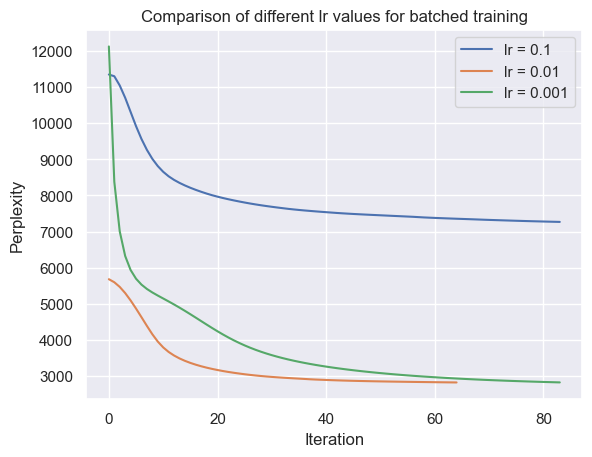

In [7]:
sns.set_theme()

for lr, values in lr_to_metric.items():
    # The value of perplexity on the first step is usually very high, so we skip it
    plt.plot(values[1:], label=f'lr = {lr}')

plt.title('Comparison of different lr values for batched training')
plt.yticks(jnp.arange(3000, 13000, 1000))
plt.xlabel('Iteration')
plt.ylabel('Perplexity')
plt.legend()
plt.show()

As we can see from this example, choosing the learning rate parameter greatly affects convergence and quality of the model.